In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import maketab as mt

In [2]:
'''
def norm(data):
    min_val = np.min(data)
    max_val = np.max(data)
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data

def data(l):
    t = np.arange(l)
    x = 0.3*np.sin(t/5)
    x += (-1)*np.exp(t/l)
    x += np.random.normal(0, 0.1, l)
    return np.array(norm(x))
'''

'\ndef norm(data):\n    min_val = np.min(data)\n    max_val = np.max(data)\n    scaled_data = (data - min_val) / (max_val - min_val)\n    return scaled_data\n\ndef data(l):\n    t = np.arange(l)\n    x = 0.3*np.sin(t/5)\n    x += (-1)*np.exp(t/l)\n    x += np.random.normal(0, 0.1, l)\n    return np.array(norm(x))\n'

In [3]:
norm_upper = 4
norm_lower = 2
def norm(signal):
    signal = (signal - norm_lower) / (norm_upper - norm_lower)
    signal = signal[50:]
    return signal

def load_data(path_dir='data/5-2-25/'):
    t, signal = mt.battery(path_dir)
    return norm(signal)[1000:3000]

In [4]:
class CreateDataset(Dataset):
    def __init__(self, data, n, m):
        self.data = data
        self.n = n  # Sequence length
        self.m = m  # Prediction length
        self.total_length = len(self.data)

    def __len__(self):
        return self.total_length - self.n - self.m + 1

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.n]
        y = self.data[idx + self.n:idx + self.n + self.m]
        x = torch.tensor(x, dtype=torch.float32).unsqueeze(-1)  # Add feature dimension
        y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)
        return x, y

In [5]:
#'''
class SequencePredictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1, num_layers=2):
        super(SequencePredictor, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out
#'''

In [6]:
'''
class SequencePredictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1, num_layers=2):
        super(SequencePredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        out, _ = self.lstm(x)  # out shape: (batch_size, seq_len, hidden_size)
        # We only want to predict based on the last time step
        out = out[:, -1, :]  # Take the last time step
        out = self.fc(out)  # Shape: (batch_size, output_size)
        return out
'''

'\nclass SequencePredictor(nn.Module):\n    def __init__(self, input_size=1, hidden_size=64, output_size=1, num_layers=2):\n        super(SequencePredictor, self).__init__()\n        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)\n        self.fc = nn.Linear(hidden_size, output_size)\n        \n    def forward(self, x):\n        # x shape: (batch_size, seq_len, input_size)\n        out, _ = self.lstm(x)  # out shape: (batch_size, seq_len, hidden_size)\n        # We only want to predict based on the last time step\n        out = out[:, -1, :]  # Take the last time step\n        out = self.fc(out)  # Shape: (batch_size, output_size)\n        return out\n'

In [7]:
# Training function
def train_model(model, dataloader, epochs=1000, learning_rate=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    losses = []
    for epoch in range(epochs):
        for batch_x, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y.squeeze(-1)[:, -pred_len:])
            loss.backward()
            optimizer.step()
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.6f}')
        losses.append(loss.item())
    return model

# Evaluation function
def evaluate_model(model, data, seq_len, pred_len):
    model.eval()
    t = np.arange(len(data))
    #t = np.arange(i+seq_len+pred_len)
    with torch.no_grad():
        plt.figure(figsize=(18, 6))
        for i in range(0, len(data)-seq_len-pred_len+1, seq_len+pred_len):
            test_input = torch.tensor(data[i:i+seq_len], dtype=torch.float32).unsqueeze(-1).unsqueeze(0)
            prediction = model(test_input)
            
            # Plotting
            plt.plot(t[i:i+seq_len], data[i:i+seq_len], color='tab:blue')
            plt.plot(t[i+seq_len:i+seq_len+pred_len], data[i+seq_len:i+seq_len+pred_len], color='tab:orange')
            plt.plot(t[i+seq_len:i+seq_len+pred_len], prediction.numpy().flatten(), color='tab:green')
        plt.show()

In [8]:
seq_len = 30
pred_len = 60
batch_size = 16
hidden_size = 32
num_layers = 2
epochs = 100
learning_rate = 0.001

data = load_data()

dataset = CreateDataset(data, seq_len, pred_len)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize, train and evaluate the model
model = SequencePredictor(input_size=1, hidden_size=hidden_size, 
                         output_size=pred_len, num_layers=num_layers)
model = train_model(model, dataloader, epochs, learning_rate)

Epoch 0, Loss: 0.000934
Epoch 10, Loss: 0.000080
Epoch 20, Loss: 0.000054
Epoch 30, Loss: 0.000092
Epoch 40, Loss: 0.000032
Epoch 50, Loss: 0.000042
Epoch 60, Loss: 0.000043
Epoch 70, Loss: 0.000038
Epoch 80, Loss: 0.000044
Epoch 90, Loss: 0.000037


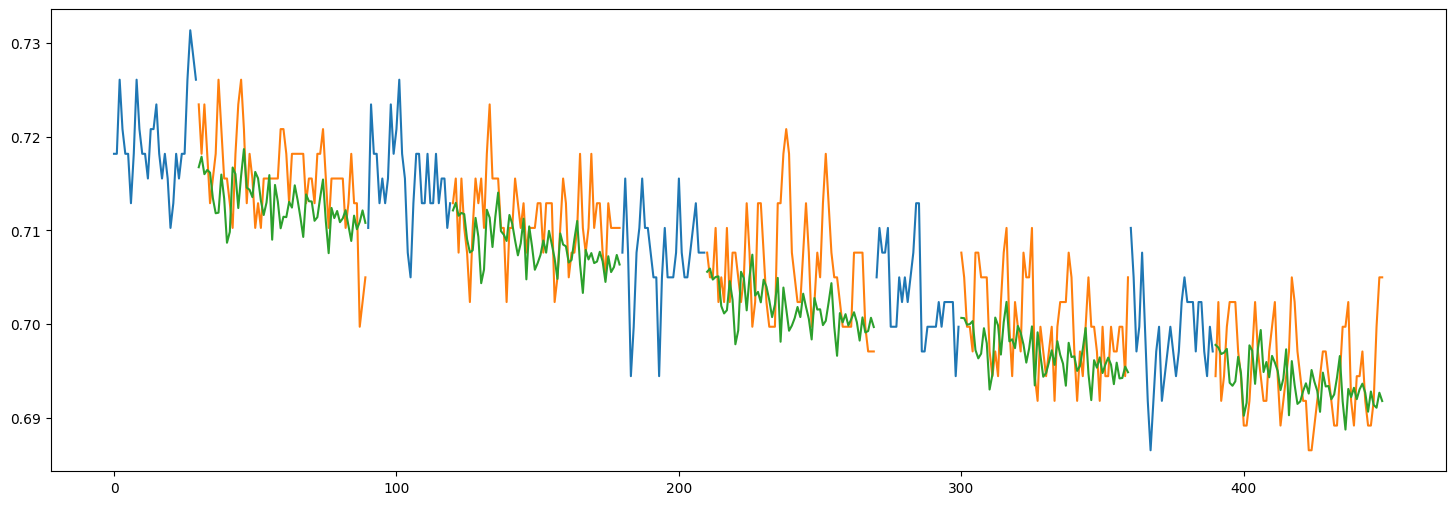

In [9]:
evaluate_model(model, data[:500], seq_len, pred_len)